# Turn irrigation data into a geodataframe

In [1]:
from shapely.geometry import Point
import geopandas as gpd
import os
import rasterio
import numpy as np
import pandas as pd

data_loc = '/home/waves/data/Africa_Irrigation/Data'

In [2]:
# Read in the country boundaries shapefile and add a column for which country each point is in
# Load the country boundaries
world_boundaries_path = os.path.join(data_loc, 'anna', 'intermediate', 'world_boundaries', 'world-administrative-boundaries.shp')
world_boundaries = gpd.read_file(world_boundaries_path)

In [3]:
year = 1980

def get_aei(year, source='Mehta', aei_dir=os.path.join(data_loc, 'anna', 'raw', 'AEI')):

    if source == 'Mehta':
        print(f"Reading AEI data for {year} from Mehta")
        file_path = os.path.join(aei_dir, f"G_AEI_{year}.ASC")
    elif source == 'Meier':
        print(f"Reading AEI data for {year} from Meier")
        file_path = os.path.join(aei_dir, f"MEIER_G_AEI_{year}.ASC")
    else: 
        raise ValueError("source must be 'Mehta' or 'Meier'")

    with rasterio.open(file_path) as src:
        # Read the raster data
        data = src.read(1)  # Assuming the raster has one band
        
        # Find rows and cols where the data is neither NaN nor zero
        valid_mask = (~np.isnan(data)) & (data != 0)
        rows, cols = np.where(valid_mask)  # Get indices of valid data (not NaN and not zero)

        xs, ys = src.xy(rows, cols)  # Convert rows and cols to x, y coordinates

        # Create a list of Points and associate them with raster values
        points = [Point(x, y) for x, y in zip(xs, ys)]
        values = data[rows, cols]  # Corresponding values from the raster

    # Create a GeoDataFrame with the points and values
    # For some reason the AEI data doesn't have a crs but it is WGS84 which is the same as the world boundaries
    aei = gpd.GeoDataFrame({'Longitude': xs, 'Latitude': ys, 'Year': year, 'AEI': values}, geometry=points, crs=world_boundaries.crs)

    # Spatial join the points with the country boundaries
    aei_c = gpd.sjoin(aei, world_boundaries, how='left', predicate='intersects') # Takes ~15 seconds

    # Save the data
    os.makedirs(os.path.join(data_loc, 'anna', 'intermediate', 'aei'), exist_ok=True)
    aei_c.to_file(os.path.join(data_loc, 'anna', 'intermediate', 'aei', f'{source}_aei_{year}.shp'))

    return aei_c

Reading AEI data for 1980 from Mehta


/tmp/ipykernel_3831183/3359567001.py:37: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  aei_c.to_file(os.path.join(data_loc, 'anna', 'intermediate', 'aei', f'{source}_aei_{year}.shp'))


<Axes: >

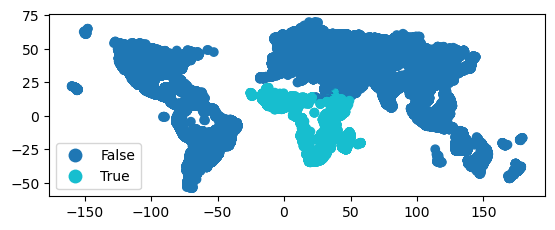

In [4]:
# test on one year
aei_c = get_aei(1980, source='Mehta')
aei_c.plot(column='in_ssa', legend=True) # Takes ~20 seconds

In [5]:
# get all data for Mehta
for year in range(1980, 2016, 5):
    get_aei(year, source='Mehta')

# get all data for Meier
for year in range(1980, 2016, 5):
    get_aei(year, source='Meier')

Reading AEI data for 1980 from Mehta


/tmp/ipykernel_3831183/3359567001.py:37: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  aei_c.to_file(os.path.join(data_loc, 'anna', 'intermediate', 'aei', f'{source}_aei_{year}.shp'))
